### Light Intensity (Is) & Pollution Level Predictor

This project demonstrates the prediction of light intensity ('Is') and associated pollution levels using the "Monitoring Light Pollution Dataset."

**Kaggle Dataset:** [Monitoring Light Pollution](https://www.kaggle.com/datasets/hamtaghanbaripour/monitoring-light-pollution)

**GitHub Repository:** [Light Intensity Prediction App](https://github.com/naaivvv/light_intensity_prediction_app.git)

---

Edwin P. Bayog Jr. BSCpE 3-A

CPE333-V Environmental Engineering

---

In [1]:
# MANUAL KAGGLE SETUP IF YOU ARE IN COLAB (IGNORE IF RUN LOCALLY)
# Install the Kaggle library
!pip install kaggle --quiet

# Create a directory for the Kaggle API token
!mkdir -p ~/.kaggle

# Upload your kaggle.json file
# (You need to download this from your Kaggle account: My Account > API > Create New API Token)
# In Colab, run this cell, and it will prompt you to upload the file.

In [4]:
# Copy the kaggle.json to the correct directory and set permissions
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d hamtaghanbaripour/monitoring-light-pollution -p /content/light-pollution --unzip

Dataset URL: https://www.kaggle.com/datasets/hamtaghanbaripour/monitoring-light-pollution
License(s): apache-2.0
  0% 0.00/3.78k [00:00<?, ?B/s]
100% 3.78k/3.78k [00:00<00:00, 16.0MB/s]


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.18.0


In [ ]:
import os
# print(os.listdir('/content/light-pollution/')) # IF IN COLAB
print(os.listdir('light-pollution/')) # IF LOCAL

try:
    # df = pd.read_csv('/content/light-pollution/LP drone data.csv', sep=';') # IF IN COLAB
    df = pd.read_csv('light-pollution/LP drone data.csv', sep=';') # IF LOCAL
    print("Dataset loaded successfully with semicolon delimiter!")
except FileNotFoundError:
    print("Error: 'LP drone data.csv' not found. Please check the file name and path.")
except Exception as e:
    print(f"An error occurred during CSV loading: {e}")


if 'df' in locals() and not df.empty:
    print("\nFirst 5 rows of the dataset:")
    print(df.head())

    print("\nDataset information:")
    df.info()

    print("\nDescriptive statistics:")
    print(df.describe())

    print("\nMissing values per column:")
    print(df.isnull().sum())

    # Clean column names (remove spaces, special characters for easier use)
    df.columns = df.columns.str.replace(' ', '_').str.replace('[^A-Za-z0-9_]+', '', regex=True)
    print("\nCleaned column names:")
    print(df.columns.tolist())
    print("\nFirst 5 rows with cleaned column names:")
    print(df.head())

else:
    print("DataFrame 'df' is not loaded or is empty. Please check the loading step.")

['LP drone data.csv']
Dataset loaded successfully with semicolon delimiter!

First 5 rows of the dataset:
  dataset  Altitude (m)  Exposure time (sec)  NSB (mpsas)        Is        Rs  \
0      A1            70                 0.16        14.17 -1.455654 -1.243168   
1      A1            70                 0.16        14.15 -1.253555 -1.041241   
2      A1            70                 0.16        15.89 -1.734109 -1.516880   
3      A1            70                 0.16        14.33 -1.586858 -1.404539   
4      A1            70                 0.16        14.29 -1.487974 -1.304777   

         Gs        Bs  
0 -1.496825 -2.883574  
1 -1.294257 -2.784096  
2 -1.780017 -2.817938  
3 -1.613596 -2.846712  
4 -1.514620 -2.845205  

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dataset              134 non-nul

In [6]:
if 'df' in locals() and not df.empty:
    target_column = 'Is'

    if target_column not in df.columns:
        print(f"Error: New target column '{target_column}' not found after cleaning. Available columns: {df.columns.tolist()}")
    else:
        print(f"Using '{target_column}' as the NEW target variable.")
        df.dropna(subset=[target_column], inplace=True)
        print(f"\nShape after dropping rows with missing {target_column}: {df.shape}")

        numerical_features_to_use = ['Altitude_m', 'Exposure_time_sec', 'NSB_mpsas', 'Rs', 'Gs', 'Bs']

        categorical_features = []

        if 'dataset' in df.columns:
            categorical_features.append('dataset')
            print(f"Categorical feature found: {categorical_features}")

        final_numerical_features = [col for col in numerical_features_to_use if col in df.columns and col != target_column]
        print(f"Final numerical features selected for X: {final_numerical_features}")

        if not final_numerical_features and not categorical_features:
            print("Error: No features selected. Please check column names, target column, and feature lists.")
        else:
            if final_numerical_features:
                X_numerical = df[final_numerical_features].copy()

                for col in X_numerical.columns:
                    if X_numerical[col].isnull().sum() > 0:
                        X_numerical[col].fillna(X_numerical[col].median(), inplace=True)
                        print(f"Filled missing values in numerical feature '{col}' with median.")
            else:
                X_numerical = pd.DataFrame()

            X_categorical_encoded_list = []
            if categorical_features:
                for cat_col in categorical_features:
                    if df[cat_col].isnull().sum() > 0:
                         df[cat_col].fillna(df[cat_col].mode()[0], inplace=True)
                         print(f"Filled missing values in categorical feature '{cat_col}' with mode.")
                    dummies = pd.get_dummies(df[cat_col], prefix=cat_col, dummy_na=False)
                    X_categorical_encoded_list.append(dummies)

            if X_categorical_encoded_list:
                X_categorical_encoded = pd.concat(X_categorical_encoded_list, axis=1)
                if not X_numerical.empty:
                    X = pd.concat([X_numerical, X_categorical_encoded], axis=1)
                else:
                    X = X_categorical_encoded
                print("Applied One-Hot Encoding to categorical features and combined with numerical features.")
            elif not X_numerical.empty:
                X = X_numerical
                print("Using only numerical features.")
            else:
                X = pd.DataFrame()
                print("Warning: X DataFrame is empty before defining y.")

            y = df[target_column].copy()

            if X.empty:
                print("CRITICAL Error: Feature set X is empty after processing. Check feature selection and data.")
            else:
                print("\nFeatures (X) head after processing:")
                print(X.head())
                print("\nTarget (y) head (should be 'Is' values):")
                print(y.head())
                print(f"\nShape of X: {X.shape}, Shape of y: {y.shape}")
                print("\nMissing values in X after imputation (sum over all columns):")
                print(X.isnull().sum().sum())
                print("\nMissing values in y (should be 0):")
                print(y.isnull().sum())
else:
    if 'df' not in locals() or df.empty:
        print("DataFrame 'df' is not loaded or is empty. Please check the loading step.")

Using 'Is' as the NEW target variable.

Shape after dropping rows with missing Is: (134, 8)
Categorical feature found: ['dataset']
Final numerical features selected for X: ['Altitude_m', 'Exposure_time_sec', 'NSB_mpsas', 'Rs', 'Gs', 'Bs']
Applied One-Hot Encoding to categorical features and combined with numerical features.

Features (X) head after processing:
   Altitude_m  Exposure_time_sec  NSB_mpsas        Rs        Gs        Bs  \
0          70               0.16      14.17 -1.243168 -1.496825 -2.883574   
1          70               0.16      14.15 -1.041241 -1.294257 -2.784096   
2          70               0.16      15.89 -1.516880 -1.780017 -2.817938   
3          70               0.16      14.33 -1.404539 -1.613596 -2.846712   
4          70               0.16      14.29 -1.304777 -1.514620 -2.845205   

   dataset_A1  dataset_A2  dataset_B1  dataset_B2  dataset_C1  dataset_C2  
0        True       False       False       False       False       False  
1        True       Fa

In [7]:
if 'X' in locals() and 'y' in locals() and not X.empty:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    print("\nScaled features (X_scaled) sample (based on new feature set):")
    print(X_scaled[:5])

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    print(f"\nX_train shape: {X_train.shape}, y_train shape: {y_train.shape} (y_train now contains 'Is' values)")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape} (y_test now contains 'Is' values)")
else:
    print("Error: X or y is not defined or X is empty. Please check the previous block for errors in feature selection or data loading after changing the target variable.")


Scaled features (X_scaled) sample (based on new feature set):
[[-0.6992059  -0.65557725 -0.93227072  0.25313179  0.38803357 -0.751933
   2.92770022 -0.40646942 -0.45520018 -0.47891314 -0.47891314 -0.51395617]
 [-0.6992059  -0.65557725 -0.9631788   0.76136026  0.86038947 -0.59221517
   2.92770022 -0.40646942 -0.45520018 -0.47891314 -0.47891314 -0.51395617]
 [-0.6992059  -0.65557725  1.72582413 -0.43576944 -0.27232123 -0.64655154
   2.92770022 -0.40646942 -0.45520018 -0.47891314 -0.47891314 -0.51395617]
 [-0.6992059  -0.65557725 -0.68500608 -0.15302015  0.11574293 -0.69274983
   2.92770022 -0.40646942 -0.45520018 -0.47891314 -0.47891314 -0.51395617]
 [-0.6992059  -0.65557725 -0.74682224  0.09806766  0.34653824 -0.69033043
   2.92770022 -0.40646942 -0.45520018 -0.47891314 -0.47891314 -0.51395617]]

X_train shape: (107, 12), y_train shape: (107,) (y_train now contains 'Is' values)
X_test shape: (27, 12), y_test shape: (27,) (y_test now contains 'Is' values)


--- Learning Rate Finder ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,033 (47.00 KB)

 Trainable params: 12,033 (47.00 KB)

 Non-trainable params: 0 (0.00 B)


Starting learning rate search for 100 epochs, from LR=1.0e-07 to LR=1.0e-01...
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.1897 - mae: 1.7126 - mse: 3.1897 - rmse: 1.7859 - learning_rate: 1.0000e-07
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.0104 - mae: 1.6648 - mse: 3.0104 - rmse: 1.7337 - learning_rate: 1.1498e-07
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.0827 - mae: 1.6861 - mse: 3.0827 - rmse: 1.7558 - learning_rate: 1.3219e-07
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.0637 - mae: 1.6852 - mse: 3.0637 - rmse: 1.7501 - learning_rate: 1.5199e-07
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.9125 - mae: 1.6501 - mse: 2.9125 - rmse: 1.7065 - learning_rate: 1.7475e-07
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.1174 - mae: 1.6835 - mse: 3.1174 - rmse: 1.7650 - learning_rate: 2.0092e-07
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.2990 - mae: 1.7377 - mse: 3.2990 - rmse: 1.8

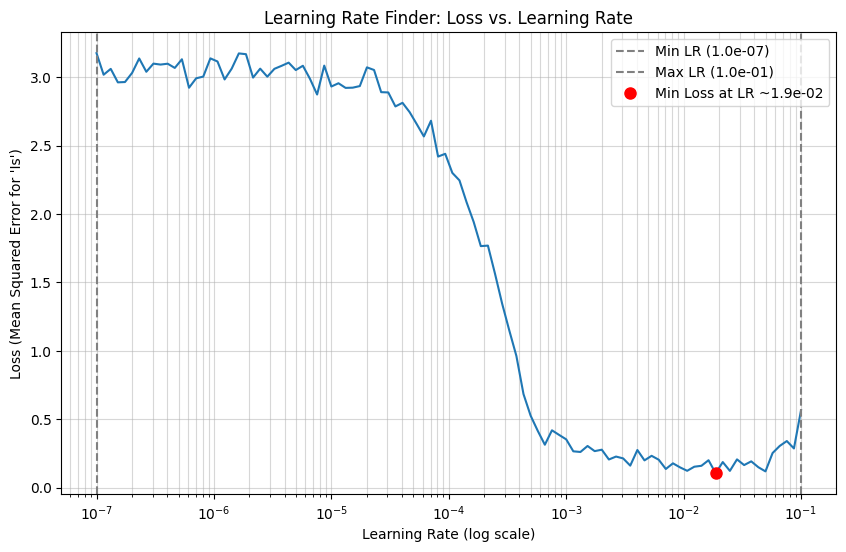

In [10]:
    def build_model_for_lr_search(input_shape):
        model = keras.Sequential([
            layers.Dense(128, activation='relu', input_shape=input_shape),
            layers.Dropout(0.3),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(32, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(1)  # Output layer for regression
        ])
        return model

    model_ls = build_model_for_lr_search(input_shape=[X_train.shape[1]])


    model_ls.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-7), # Start with a very small LR
                     loss='mean_squared_error',
                     metrics=['mae', 'mse', tf.keras.metrics.RootMeanSquaredError(name='rmse')])

    print("--- Learning Rate Finder ---")
    model_ls.summary()

    N_EPOCHS_LR_FIND = 100
    MIN_LR = 1e-7
    MAX_LR = 1e-1

    def lr_exp_scheduler(epoch, lr):
        if epoch == 0:
            return MIN_LR
        else:
            factor = (MAX_LR / MIN_LR)**(1 / (N_EPOCHS_LR_FIND - 1)) if N_EPOCHS_LR_FIND > 1 else 1.0
            new_lr = MIN_LR * (factor ** epoch)
            return min(new_lr, MAX_LR)


    lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(lr_exp_scheduler)

    print(f"\nStarting learning rate search for {N_EPOCHS_LR_FIND} epochs, from LR={MIN_LR:.1e} to LR={MAX_LR:.1e}...")
    history_lr_find = model_ls.fit(
        X_train, y_train,
        epochs=N_EPOCHS_LR_FIND,
        batch_size=32,
        callbacks=[lr_scheduler_callback],
        verbose=1
    )

    print("\nPlotting Loss vs. Learning Rate...")
    learning_rates_used = history_lr_find.history['learning_rate']
    losses = history_lr_find.history['loss']

    plt.figure(figsize=(10, 6))
    plt.plot(learning_rates_used, losses)
    plt.xscale('log')
    plt.xlabel("Learning Rate (log scale)")
    plt.ylabel("Loss (Mean Squared Error for 'Is')")
    plt.title("Learning Rate Finder: Loss vs. Learning Rate")
    plt.grid(True, which="both", ls="-", alpha=0.5)
    plt.axvline(x=MIN_LR, color='gray', linestyle='--', label=f'Min LR ({MIN_LR:.1e})')
    plt.axvline(x=MAX_LR, color='gray', linestyle='--', label=f'Max LR ({MAX_LR:.1e})')
    if len(losses) > 0 and len(learning_rates_used) > 0:
        min_loss_idx = np.argmin(losses)
        if min_loss_idx < len(learning_rates_used):
             min_loss_lr = learning_rates_used[min_loss_idx]
             plt.plot(min_loss_lr, losses[min_loss_idx], 'ro', markersize=8, label=f'Min Loss at LR ~{min_loss_lr:.1e}')

    plt.legend()
    plt.show()

In [14]:
if 'X_train' in locals() and X_train.shape[0] > 0 and X_train.shape[1] > 0:
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=[X_train.shape[1]]),
        layers.Dropout(0.3),

        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),

        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)

    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae', 'mse', tf.keras.metrics.RootMeanSquaredError(name='rmse')])

    model.summary()
else:
    print("Error: X_train is not defined, empty, or has no features. Cannot build model. Check previous steps.")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,033 (47.00 KB)

 Trainable params: 12,033 (47.00 KB)

 Non-trainable params: 0 (0.00 B)


Starting model training (target: 'Is' - Intensity)...
Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - loss: 2.1263 - mae: 1.2109 - mse: 2.1263 - rmse: 1.4538 - val_loss: 0.7948 - val_mae: 0.8250 - val_mse: 0.7948 - val_rmse: 0.8915
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.8194 - mae: 0.7872 - mse: 0.8194 - rmse: 0.9049 - val_loss: 0.2912 - val_mae: 0.4661 - val_mse: 0.2912 - val_rmse: 0.5397
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2922 - mae: 0.4441 - mse: 0.2922 - rmse: 0.5405 - val_loss: 0.2885 - val_mae: 0.4630 - val_mse: 0.2885 - val_rmse: 0.5371
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.7643 - mae: 0.6175 - mse: 0.7643 - rmse: 0.8729 - val_loss: 0.5581 - val_mae: 0.6911 - val_mse: 0.5581 - val_rmse: 0.7471
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.6280 - mae: 0.6801 - mse: 0.6280 - rmse: 0.7922 - val_loss: 0.7610 - val_mae: 0.8041 - val_mse: 0.7610 - val_rmse: 0.8724
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━

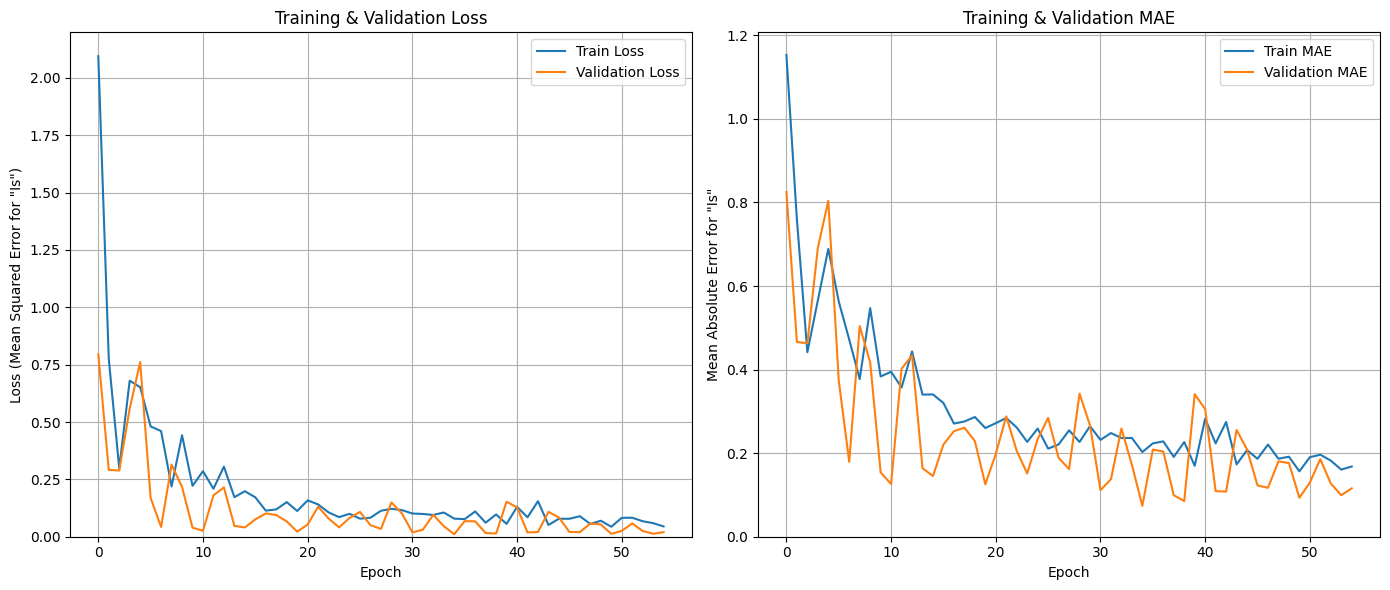

In [15]:
if 'model' in locals() and 'X_train' in locals() and 'y_train' in locals() and X_train.shape[0] > 0 :
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,

        restore_best_weights=True
    )

    print("\nStarting model training (target: 'Is' - Intensity)...")
    history = model.fit(
        X_train, y_train,
        epochs=200,
        validation_split=0.2,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )
    print("\nModel training finished.")
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (Mean Squared Error for "Is")')
    plt.plot(hist['epoch'], hist['loss'], label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'], label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.ylim(bottom=0)
    plt.subplot(1, 2, 2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error for "Is"')
    plt.plot(hist['epoch'], hist['mae'], label='Train MAE')
    plt.plot(hist['epoch'], hist['val_mae'], label='Validation MAE')

    plt.title('Training & Validation MAE')
    plt.legend()
    plt.grid(True)
    plt.ylim(bottom=0)

    plt.tight_layout()
    plt.show()
else:
    print("Error: Model or training data not available. Cannot train model. Check previous steps.")


Evaluating model on the test set (target: 'Is' - Intensity)...

Test Set Performance (for predicting 'Is'):
  Mean Squared Error (MSE): 0.0067
  Root Mean Squared Error (RMSE): 0.0817
  Mean Absolute Error (MAE): 0.0626
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
  R-squared (R²): 0.9481


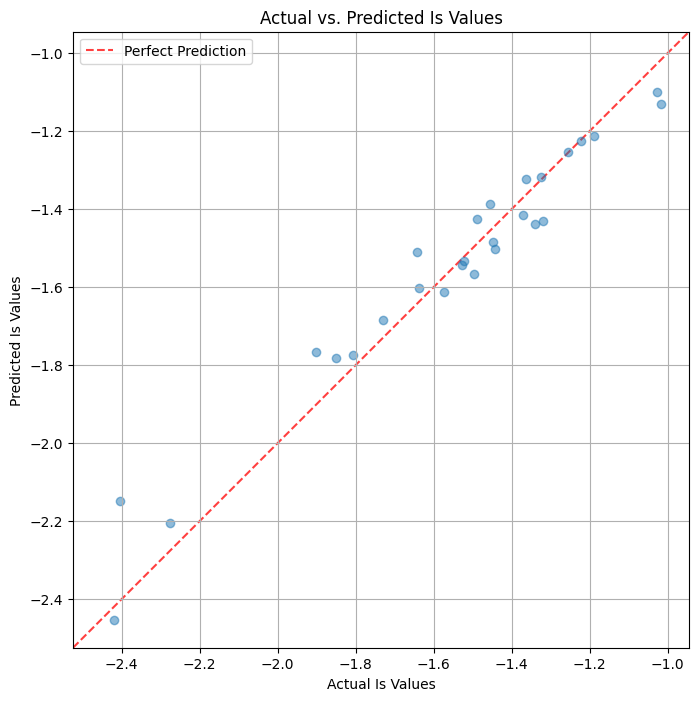

In [16]:
if 'model' in locals() and 'X_test' in locals() and 'y_test' in locals() and X_test.shape[0] > 0:
    print("\nEvaluating model on the test set (target: 'Is' - Intensity)...")
    if 'target_column' not in locals() or target_column != 'Is':
        print(f"Warning: 'target_column' is not 'Is'. Current value: {locals().get('target_column', 'Not defined')}. Plot labels might be misleading.")

    loss, mae, mse, rmse = model.evaluate(X_test, y_test, verbose=0)

    print(f"\nTest Set Performance (for predicting 'Is'):")
    print(f"  Mean Squared Error (MSE): {mse:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")

    y_pred = model.predict(X_test).flatten()

    r2 = r2_score(y_test, y_pred)
    print(f"  R-squared (R²): {r2:.4f}")
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel(f'Actual {target_column} Values')
    plt.ylabel(f'Predicted {target_column} Values')
    plt.title(f'Actual vs. Predicted {target_column} Values')

    min_val = min(min(y_test), min(y_pred))
    max_val = max(max(y_test), max(y_pred))
    buffer = (max_val - min_val) * 0.05
    lims = [min_val - buffer, max_val + buffer]

    plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='Perfect Prediction')
    plt.xlim(lims)
    plt.ylim(lims)
    plt.legend()
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

else:
    print("Error: Model or test data not available. Cannot evaluate model. Check previous steps for data preparation and model training.")

In [17]:
if 'model' in locals() and \
   'scaler' in locals() and \
   'X' in locals() and not X.empty and \
   'target_column' in locals():

    sample_unscaled_data_from_X = X.iloc[[0]].copy()
    print("\nExample unscaled data point (first row of current processed X):")
    print(sample_unscaled_data_from_X)
    print(f"(Note: These are the features used to predict '{target_column}')")

    new_data_scaled = scaler.transform(sample_unscaled_data_from_X)

    predicted_value = model.predict(new_data_scaled)

    print(f"\nPredicted {target_column} (Intensity) for the sample data point: {predicted_value[0][0]:.4f}")
else:
    print("Error: 'model', 'scaler', 'X' (processed unscaled features), or 'target_column' is not defined or 'X' is empty.")
    print("Please ensure all previous cells, including data preprocessing for the new target ('Is'), model training, and scaler fitting, have been run successfully.")


Example unscaled data point (first row of current processed X):
   Altitude_m  Exposure_time_sec  NSB_mpsas        Rs        Gs        Bs  \
0          70               0.16      14.17 -1.243168 -1.496825 -2.883574   

   dataset_A1  dataset_A2  dataset_B1  dataset_B2  dataset_C1  dataset_C2  
0        True       False       False       False       False       False  
(Note: These are the features used to predict 'Is')
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step

Predicted Is (Intensity) for the sample data point: -1.4092


In [25]:
if 'model' in locals() and \
   'X_test' in locals() and \
   'y_test' in locals() and \
   'X' in locals() and \
   'scaler' in locals() and \
   'target_column' in locals():

    print(f"\n--- Simplified Prediction View (Target: {target_column}) ---")

    y_pred_test = model.predict(X_test).flatten()

    if not isinstance(y_test, pd.Series):
        print("Warning: y_test is not a Pandas Series. Original indices might be lost, so original features cannot be easily displayed alongside.")
        comparison_df = pd.DataFrame({
            f'Actual_{target_column}': y_test,
            f'Predicted_{target_column}': y_pred_test
        })
    else:
        comparison_df = pd.DataFrame({
            f'Actual_{target_column}': y_test,
            f'Predicted_{target_column}': y_pred_test
        }, index=y_test.index)

        comparison_df['Difference'] = comparison_df[f'Actual_{target_column}'] - comparison_df[f'Predicted_{target_column}']

        original_features_for_test_set = X.loc[y_test.index]

        explicit_features_to_show = ['Altitude_m',
                                     'Exposure_time_sec',
                                     'NSB_mpsas', # This is now a feature
                                     'Rs',
                                     'Gs',
                                     'Bs']
        features_to_display = [f for f in explicit_features_to_show if f in original_features_for_test_set.columns]

        print(f"\nDisplaying these original (unscaled) features for context: {features_to_display}")
        for feature_name in features_to_display:
            if feature_name in original_features_for_test_set.columns:
                comparison_df[feature_name + '_original'] = original_features_for_test_set[feature_name]
            else:
                print(f"Warning: Desired feature '{feature_name}' for display not found in original_features_for_test_set (X.loc[y_test.index]).")

    num_examples_to_show = 15
    print(f"\nShowing comparison for the first {num_examples_to_show} test samples (Target: {target_column}):")

    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)

    print(comparison_df.head(num_examples_to_show))

    if 'Difference' in comparison_df.columns:
        print(f"\nExamples with the largest absolute difference (Target: {target_column}):")
        comparison_df_sorted_by_diff = comparison_df.reindex(comparison_df['Difference'].abs().sort_values(ascending=False).index)
        print(comparison_df_sorted_by_diff.head(5))
    else:
        print("\n'Difference' column not available for sorting by difference (likely because y_test was not a Pandas Series).")

    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')

else:
    print("Error: One or more required variables (model, X_test, y_test, X, scaler, target_column) are not defined or X is empty.")
    print("Please ensure all previous cells for data loading, preprocessing for the new target ('Is'), model training, and evaluation have been run successfully.")


--- Simplified Prediction View (Target: Is) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

Displaying these original (unscaled) features for context: ['Altitude_m', 'Exposure_time_sec', 'NSB_mpsas', 'Rs', 'Gs', 'Bs']

Showing comparison for the first 15 test samples (Target: Is):
     Actual_Is  Predicted_Is  Difference  Altitude_m_original  Exposure_time_sec_original  NSB_mpsas_original  Rs_original  Gs_original  Bs_original
127  -1.027547     -1.100010    0.072463                   70                        0.50               14.62    -0.850385    -1.050934    -2.475907
66   -1.850787     -1.782914   -0.067873                  100                        0.16               15.52    -1.580082    -1.929555    -2.868075
104  -2.402913     -2.148725   -0.254187                   70                        0.25               14.52    -2.117109    -2.502417    -2.944217
19   -1.321057     -1.430230    0.109173                  100                        0.16               14.41    -1.096765    

In [19]:
import joblib
import json

model.save('light_pollution_model.keras')

joblib.dump(scaler, 'scaler.pkl')

feature_names = X.columns.tolist()
with open('feature_names.json', 'w') as f:
    json.dump(feature_names, f)

if 'dataset' in df.columns:
    original_dataset_categories = df['dataset'].unique().tolist()
    original_dataset_categories = [str(cat) for cat in original_dataset_categories]
    with open('original_dataset_categories.json', 'w') as f:
        json.dump(original_dataset_categories, f)
    print("Original dataset categories saved.")
else:
    with open('original_dataset_categories.json', 'w') as f:
        json.dump([], f)
    print("'dataset' column not found in df, saved empty list for categories.")


print("Model saved as light_pollution_model.keras")
print("Scaler saved as scaler.pkl")
print("Feature names saved as feature_names.json")

Original dataset categories saved.
Model saved as light_pollution_model.keras
Scaler saved as scaler.pkl
Feature names saved as feature_names.json


In [20]:
!pip install streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 79.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.1 MB/s eta 0:00:00


In [26]:
%%writefile app.py

import streamlit as st
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
import json

st.set_page_config(page_title="Light Intensity (Is) & Pollution Level Predictor", layout="wide")

# --- Constants for file paths and value ranges ---
MODEL_PATH = 'light_pollution_model.keras'
SCALER_PATH = 'scaler.pkl'
FEATURES_PATH = 'feature_names.json'
CATEGORIES_PATH = 'original_dataset_categories.json'

# Define the 'Is' value range for pollution visualization
MIN_IS_VALUE_FOR_POLLUTION_RANGE = -2.5
MAX_IS_VALUE_FOR_POLLUTION_RANGE = -0.5

# --- Cached Resource Loading Functions ---
@st.cache_resource
def load_model():
    try:
        model = tf.keras.models.load_model(MODEL_PATH)
        return model
    except Exception as e:
        st.error(f"Error loading model: {e}. Ensure '{MODEL_PATH}' is trained for 'Is' and is a valid Keras model file.")
        st.stop()

@st.cache_resource
def load_scaler():
    try:
        scaler = joblib.load(SCALER_PATH)
        return scaler
    except Exception as e:
        st.error(f"Error loading scaler: {e}. Ensure '{SCALER_PATH}' is compatible with the features for 'Is' prediction.")
        st.stop()

@st.cache_data
def load_feature_info():
    try:
        with open(FEATURES_PATH, 'r') as f:
            all_feature_names = json.load(f)
        with open(CATEGORIES_PATH, 'r') as f:
            original_dataset_categories = json.load(f)
        return all_feature_names, original_dataset_categories
    except Exception as e:
        st.error(f"Error loading feature info: {e}. Ensure JSON files list correct features for 'Is' prediction.")
        st.stop()

# --- Load Resources ---
model = load_model()
scaler = load_scaler()
all_feature_names, original_dataset_categories = load_feature_info()

# --- Prediction Display Function ---
def display_prediction_with_pollution_level(is_value):
    is_value_pyfloat = float(is_value)

    st.metric(label="📊 Predicted Intensity (Is)", value=f"{is_value_pyfloat:.4f}")

    # --- Enhanced Progress Bar Section ---
    st.markdown("---")
    st.markdown("#### Intensity Visualization on Pollution Scale")
    st.caption(
        f"This bar shows where the predicted 'Is' value ({is_value_pyfloat:.4f}) falls within the "
        f"typical assessment range: **{MIN_IS_VALUE_FOR_POLLUTION_RANGE}** (lower pollution potential) "
        f"to **{MAX_IS_VALUE_FOR_POLLUTION_RANGE}** (higher pollution potential)."
    )

    progress_val_calculated = (is_value_pyfloat - MIN_IS_VALUE_FOR_POLLUTION_RANGE) / \
                              (MAX_IS_VALUE_FOR_POLLUTION_RANGE - MIN_IS_VALUE_FOR_POLLUTION_RANGE)
    clipped_progress_val = np.clip(float(progress_val_calculated), 0.0, 1.0)

    # Determine bar color based on 'Is' value relative to pollution thresholds
    bar_color = "#757575" # Default grey
    intensity_range_for_color = MAX_IS_VALUE_FOR_POLLUTION_RANGE - MIN_IS_VALUE_FOR_POLLUTION_RANGE

    if intensity_range_for_color > 0:
        if is_value_pyfloat < (MIN_IS_VALUE_FOR_POLLUTION_RANGE + intensity_range_for_color * 0.33):
            bar_color = "#66BB6A"  # Softer Green
        elif is_value_pyfloat < (MIN_IS_VALUE_FOR_POLLUTION_RANGE + intensity_range_for_color * 0.66):
            bar_color = "#FFA726"  # Softer Orange
        else:
            bar_color = "#EF5350"  # Softer Red

        # Adjust color if value is outside the defined range
        if is_value_pyfloat > MAX_IS_VALUE_FOR_POLLUTION_RANGE : bar_color = "#D32F2F" # Darker Red
        if is_value_pyfloat < MIN_IS_VALUE_FOR_POLLUTION_RANGE : bar_color = "#388E3C" # Darker Green

    progress_bar_html = f"""
    <div style="background-color: #e0e0e0; border-radius: 5px; padding: 3px; margin-top: 5px; margin-bottom: 5px;">
        <div style="width: {clipped_progress_val*100}%; background-color: {bar_color}; height: 24px; border-radius: 3px; text-align: center; color: white; font-weight: bold; line-height: 24px; font-size: 0.9em;">
            {clipped_progress_val*100:.0f}%
        </div>
    </div>
    """
    st.markdown(progress_bar_html, unsafe_allow_html=True)

    # Display min/max labels for the bar
    p_col1, p_col2 = st.columns([1,1])
    with p_col1:
        st.caption(f"Scale Min: {MIN_IS_VALUE_FOR_POLLUTION_RANGE}")
    with p_col2:
        st.caption(f"Scale Max: {MAX_IS_VALUE_FOR_POLLUTION_RANGE}")

    if is_value_pyfloat > MAX_IS_VALUE_FOR_POLLUTION_RANGE:
        st.warning(f"⚠️ Intensity ({is_value_pyfloat:.4f}) is **above** the defined maximum ({MAX_IS_VALUE_FOR_POLLUTION_RANGE}) for this visualization, suggesting very high pollution potential.", icon="📈")
    elif is_value_pyfloat < MIN_IS_VALUE_FOR_POLLUTION_RANGE:
        st.info(f"ℹ️ Intensity ({is_value_pyfloat:.4f}) is **below** the defined minimum ({MIN_IS_VALUE_FOR_POLLUTION_RANGE}) for this visualization, suggesting very low pollution potential.", icon="📉")

    st.markdown("---")

    # --- Estimated Pollution Level Section ---
    st.subheader("📝 Estimated Pollution Level based on Intensity (Is):")

    if intensity_range_for_color <= 0:
        st.warning("Min/Max 'Is' range for pollution interpretation is not correctly defined.")
        return

    # Define pollution levels based on 'Is' value
    if is_value_pyfloat < (MIN_IS_VALUE_FOR_POLLUTION_RANGE + intensity_range_for_color * 0.33):
        st.markdown("### <span style='color:#2E7D32;'>🌿 Low Pollution (Likely Darker/Less Populated Area)</span>", unsafe_allow_html=True)
        st.markdown("The predicted intensity suggests a lower level of artificial light, often found in areas with less human activity or effective light control.")
    elif is_value_pyfloat < (MIN_IS_VALUE_FOR_POLLUTION_RANGE + intensity_range_for_color * 0.66):
        st.markdown("### <span style='color:#FF8F00;'>🏙️ Moderate Pollution (Suburban/Transition Area)</span>", unsafe_allow_html=True)
        st.markdown("The predicted intensity indicates a noticeable presence of artificial light, typical of suburban areas or transitional zones between urban and rural environments.")
    else:
        st.markdown("### <span style='color:#C62828;'>🏭 High Pollution (Likely Densely Populated/Urban Area)</span>", unsafe_allow_html=True)
        st.markdown("The predicted intensity is high, suggesting significant artificial light sources, characteristic of densely populated urban centers or industrial areas.")

# --- Main Application ---
st.title("✨ Light Intensity (Is) & Pollution Level Predictor")
st.markdown("Input observational parameters to predict 'Is' (Intensity) and get an estimation of the associated light pollution level. Higher negative 'Is' values typically indicate less light pollution.")

if model and scaler and all_feature_names:
    st.sidebar.header("⚙️ Input Features:")
    inputs = {}

    inputs['Altitude_m'] = st.sidebar.slider("Altitude (m)", min_value=70.0, max_value=100.0, value=70.0, step=1.0, help="Altitude in meters.")
    inputs['Exposure_time_sec'] = st.sidebar.slider("Exposure Time (sec)", min_value=0.16, max_value=0.50, value=0.16, step=0.01, help="Camera exposure time in seconds.")
    inputs['NSB_mpsas'] = st.sidebar.number_input("NSB (mpsas)", min_value=13.0, max_value=18.0, value=14.5, format="%.2f", step=0.01, help="Natural Sky Brightness in magnitudes per square arcsecond.")

    st.sidebar.markdown("---") # Separator
    st.sidebar.markdown("##### Sensor Readings (Log Scale)")
    s_col1, s_col2 = st.sidebar.columns(2)
    inputs['Gs'] = s_col1.number_input("Gs (Green)", min_value=-3.0, max_value=-0.9, value=-1.66, format="%.3f", step=0.01, help="Green sensor reading (log scale).")
    inputs['Bs'] = s_col1.number_input("Bs (Blue)", min_value=-3.1, max_value=-1.1, value=-2.41, format="%.3f", step=0.01, help="Blue sensor reading (log scale).")
    inputs['Rs'] = s_col2.number_input("Rs (Red)", min_value=-2.7, max_value=-0.7, value=-1.34, format="%.3f", step=0.01, help="Red sensor reading (log scale).")
    st.sidebar.markdown("---") # Separator

    selected_dataset_category = None
    if original_dataset_categories:
        selected_dataset_category = st.sidebar.selectbox(
            "Dataset Category (Origin)",
            options=original_dataset_categories,
            index=0,
            help="Select the original dataset category if known, influences one-hot encoding."
        )
    else:
        st.sidebar.text("No 'dataset' categories found for selection.")

    if st.sidebar.button("🚀 Predict Intensity & Pollution Level", type="primary", use_container_width=True):
        input_df = pd.DataFrame(columns=all_feature_names)
        input_df.loc[0] = 0.0 # Initialize all features to 0.0

        # Assign numerical inputs
        if 'Altitude_m' in all_feature_names: input_df.at[0, 'Altitude_m'] = float(inputs['Altitude_m'])
        if 'Exposure_time_sec' in all_feature_names: input_df.at[0, 'Exposure_time_sec'] = float(inputs['Exposure_time_sec'])
        if 'NSB_mpsas' in all_feature_names: input_df.at[0, 'NSB_mpsas'] = float(inputs['NSB_mpsas'])
        if 'Rs' in all_feature_names: input_df.at[0, 'Rs'] = float(inputs['Rs'])
        if 'Gs' in all_feature_names: input_df.at[0, 'Gs'] = float(inputs['Gs'])
        if 'Bs' in all_feature_names: input_df.at[0, 'Bs'] = float(inputs['Bs'])

        # Handle one-hot encoded dataset category
        if selected_dataset_category:
            one_hot_col_name = f"dataset_{selected_dataset_category}"
            if one_hot_col_name in all_feature_names:
                input_df.at[0, one_hot_col_name] = 1.0 # Set selected category to 1.0
            else:
                st.warning(f"Warning: One-hot column '{one_hot_col_name}' not found in expected features: {all_feature_names}")

        # Ensure all columns are numeric and handle potential missing features not set by UI
        for col in input_df.columns:
            if col not in ['Altitude_m', 'Exposure_time_sec', 'NSB_mpsas', 'Rs', 'Gs', 'Bs'] and not col.startswith('dataset_'):
                 if input_df.at[0, col] == 0.0 and col in all_feature_names: # Check if it's still default
                    st.caption(f"Note: Feature '{col}' used default value 0.0 as it was not set via UI.")
            input_df[col] = pd.to_numeric(input_df[col], errors='coerce').fillna(0.0)


        if input_df.isnull().values.any():
            st.error("Error: Input data contains NaNs after processing. Check feature preparation logic.")
        else:
            try:
                input_df_float = input_df.astype(float)
                scaled_input = scaler.transform(input_df_float)
                prediction = model.predict(scaled_input)
                predicted_is_val = prediction[0][0]

                st.subheader("📈 Prediction Result:")
                display_prediction_with_pollution_level(predicted_is_val)

            except ValueError as ve:
                st.error(f"ValueError during prediction or scaling: {ve}")
                st.error("This might be due to a mismatch in expected feature columns or data types.")
                st.dataframe(input_df_float.head())
                st.text(f"Input DataFrame dtypes:\n{input_df_float.dtypes}")
            except Exception as e:
                st.error(f"An error occurred during prediction: {e}")
                st.dataframe(input_df_float.head())
                st.text(f"Input DataFrame dtypes:\n{input_df_float.dtypes}")

    st.sidebar.markdown("---")
    st.sidebar.info("Adjust feature values using the controls above and click 'Predict' to see the results.")

else:
    st.error("🔴 App Critical Error: Essential resources (model, scaler, or feature info) failed to load. Please check file paths and configurations. Application cannot run.")

# --- Footer and Credits ---
st.markdown("<br><hr style='margin-top: 30px; margin-bottom: 30px;'><br>", unsafe_allow_html=True)

st.markdown(
    """
    <div style='text-align: center; color: #4A4A4A; font-size: 0.9em;'>
        <p>Developed by: <b>Edwin P. Bayog Jr.</b><br>
        <i>BSCpE 3-A</i></p>
        <p style='margin-top: 5px;'>Course: <b>CPE333-V Environmental Engineering</b></p>
    </div>
    <br>
    """,
    unsafe_allow_html=True
)

Overwriting app.py


In [ ]:
# RUN IF YOU ARE IN LOCAL JUPYTER NOTEBOOK
!streamlit run app.py & npx localtunnel --port 8501

In [ ]:
# RUN IF YOU ARE IN COLAB
!wget -q -O - ipv4.icanhazip.com
print("Above is your Colab's public IP address, use as Tunnel Password.")

print("Starting Streamlit app in the background...")
!nohup streamlit run app.py --server.port 8501 --server.headless true --server.enableCORS false > streamlit.log &

import time
time.sleep(5)

print("Attempting to start localtunnel...")
!npx localtunnel --port 8501

34.121.24.97
Above is your Colab's public IP address, use as Tunnel Password.
Starting Streamlit app in the background...
nohup: redirecting stderr to stdout
Attempting to start localtunnel...
⠙⠹⠸⠼⠴your url is: https://stupid-places-do.loca.lt
